# Course Project: Image Analysis for cancer risk assessment (8QA01)


Welcome to the project of 8QA01! This notebook contains the steps to go through the images, measure features and display measurements, using functions in the utilities_8qa01.py module. You can add extend this by adding more functions in the module, and calling them from this notebook.


Before you start, don't forget to:

- Read the README.md file in this repository
- Do the "Getting started" [essential skills](https://github.com/tueimage/essential-skills) tutorial on Python



# Step-by-step project walkthrough

## 0. Load folders from google drive
Change colab_path to the path on google drive that contains the code.
You can browse your google drive to find this folder after running the next code cell. Your google drive is then visible under the files icon in the bar on the left as the folder gdrive. 

In [1]:
# Colab imports
from google.colab import drive
from distutils.dir_util import copy_tree
import os
import numpy

# Path to code folder in colab
colab_path = '/content/gdrive/MyDrive/Colab Notebooks/8qa01/code'

# Mount drive and change path
drive.mount('/content/gdrive/')
os.chdir(colab_path)

Mounted at /content/gdrive/


## 1. Import required python packages

These packages contain different functionality, for example matplotlib.pyplot is useful for various visualisation techniques. You can import more packages than these, as long as they are common Python packages, or you include them with your code. 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import class2020_group00_functions as util
from skimage import morphology
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

## 2. Specify data locations

Change the dataFile variable according to the image set you are using. Also change imagePath and maskPath to the paths of the folders you created containing images and masks respectively.

In [3]:
dataFile = 'class2020_group00_labels.xlsx'
imagePath = '../images'
maskPath = '../masks'

## 3. Load data

In [4]:
# copy images to colab instance
copy_tree(imagePath, '/content/images')
copy_tree(maskPath, '/content/masks')
imagePath = '/content/images'
maskPath = '/content/masks'

# read data
dframe = pd.read_excel(dataFile)

## 4. Initialise variables

In [5]:
ID = list(dframe['id'])
Melanoma = np.array(dframe['melanoma'])
numImages = len(ID)
featuresArea = np.empty([numImages,1])
featuresArea[:] = np.nan
featuresPerimeter = np.empty([numImages,1])
featuresPerimeter[:] = np.nan


## 5. Measure features for all images

In [6]:
%%time
for i in np.arange(numImages):
    
    # Define filenames related to this image
    imFile = imagePath + os.sep + ID[i] + '.jpg'
    maskFile = maskPath + os.sep + ID[i] + '_segmentation.png'
    
    # Read the images with these filenames
    im = plt.imread(imFile)
    mask = plt.imread(maskFile)
    
    # Measure features
    a, p = util.measureAreaPerimeter(mask)
    # xx, yy, zz = util.measureYourOwnFeatures(mask)
    
    # Store in the variables we created before
    featuresArea[i,0] = a
    featuresPerimeter[i,0] = p
    # featuresOther[i,0] = xx

CPU times: user 8.66 s, sys: 482 ms, total: 9.15 s
Wall time: 9.21 s


## 6. Save measured data

In [7]:
outfile = 'group2019_XY_automatic.csv'
outdata = {"id": ID, 
           "area": featuresArea.flatten(),
           "perimeter": featuresPerimeter.flatten()}

dframe_out = pd.DataFrame(outdata)
dframe_out.to_csv(outfile, index=False)

## 7. Display measured data

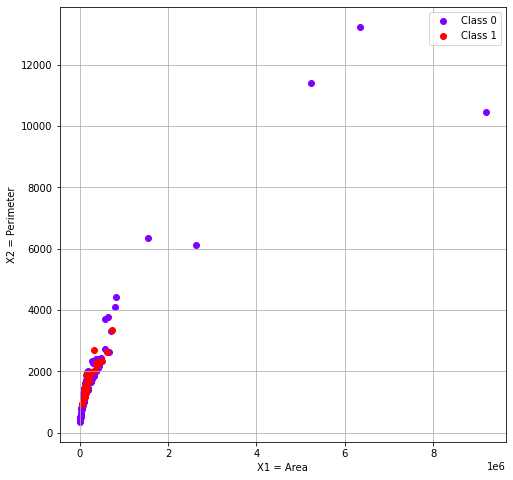

In [8]:
# Load the data you saved, then do some analysis
dframe = pd.read_csv(outfile)
ID = list(dframe['id'])
featuresArea = np.array(dframe['area'])
featuresPerimeter = np.array(dframe['perimeter'])

# Display the features measured in a scatterplot
axs = util.scatter_data(featuresArea, featuresPerimeter, Melanoma)
axs.set_xlabel('X1 = Area')
axs.set_ylabel('X2 = Perimeter')
axs.legend()

## 8. Predict labels using measurements

In [9]:
#Define K's that are tested on the validation set and the number of the current fold
Validation_K = [4, 5]
curr_fold = 0
# Load features
X = dframe.iloc[:,1:].to_numpy()
# Load labels
y = Melanoma

# Split dataset into 5 different dataset folds for cross-validation
kf = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=1)
# Predict labels for each fold using the KNN algortihm
for train_index, test_val_index in kf.split(X, y):
    # Define accuracy score and predictions for test set
    Acc_Score = 0
    y_pred_test = 0
    # split dataset into a train, validation and test dataset
    test_index , val_index = np.split(test_val_index, 2)
    X_train, X_val, X_test = X[train_index], X[val_index], X[test_index]
    y_train, y_val, y_test = y[train_index], y[val_index], y[test_index]
    # Generate predictions using knn_classifier for every K
    for K in Validation_K:
        y_pred_val, y_pred_test_curr = util.knn_classifier(X_train, y_train, X_val, X_test, K)
        Curr_Acc = accuracy_score(y_val,y_pred_val)
        # If accuracy of the predictions on the validation set is larger than the current accuracy, save predictions
        # for test set
        if Curr_Acc > Acc_Score:
            Acc_Score = Curr_Acc
            y_pred_test = y_pred_test_curr
    # Add 1 to the number of the current fold and print the accuracy on the test set for the current fold
    curr_fold += 1
    test_acc = accuracy_score(y_test,y_pred_test)
    print('Accuracy of predictions on test set of fold '+ str(curr_fold)+ ': ' + str(test_acc))

Accuracy of predictions on test set of fold 1: 0.8
Accuracy of predictions on test set of fold 2: 0.7
Accuracy of predictions on test set of fold 3: 0.7
Accuracy of predictions on test set of fold 4: 0.7
Accuracy of predictions on test set of fold 5: 0.7
